In [415]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib, pickle, gc
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random
from collections import Counter
# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load data

In [416]:
# filename = 'Datasets/final_imit_spec.pkl'
# filename = 'Datasets/final_imit_spec2_128.pkl'
subj = 'imit'
merge_train_test = False
filename = 'Datasets/final_'+subj+'_spec2_128_last.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
imit_train_images, imit_test_images, imit_y_train, imit_y_test, imit_env_train, imit_env_test = [x[0], x[1]
                                                                                                , x[2], x[3]
                                                                                                , x[4], x[5]]
print(imit_train_images.shape)
print(imit_test_images.shape)
print(imit_y_train.shape)
print(imit_y_test.shape)
print(imit_env_train.shape)
print(imit_env_test.shape)

(800, 120, 128, 128, 3)
(200, 120, 128, 128, 3)
(800, 120, 19)
(200, 120, 19)
(800,)
(200,)


In [417]:
# filename = 'Datasets/final_native_spec.pkl'
# with open(filename, 'rb') as input:
#     x = pickle.load(input)
# native_train_images, native_test_images, native_y_train, native_y_test, native_env_train, native_env_test = [x[0], x[1]
#                                                                                                 , x[2], x[3]
#                                                                                                 , x[4], x[5]]
# print(len(native_train_images))
# print(len(native_test_images))
# print(native_y_train.shape)
# print(native_y_test.shape)
# print(native_env_train.shape)
# print(native_env_test.shape)

##### STA LTA

In [418]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            if state == 1:
                stoppt = len(vec)-2
                vec2[startpt:stoppt] = vec[startpt:stoppt]
                mask[startpt:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if i < nlta and np.mean(longwin) > 150:
            vec2[0:i+nsta] = vec[0:i+nsta]
            mask[0:i+nsta] = 1
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if sum(shortwin)/sum(longwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta+int(nsta/2)
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

In [419]:
duration = 24.2
nsta_sec = 0.7
ratio = imit_env_train[0].shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,imit_env_train[0].shape[-1])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(imit_env_train)):
    vecs_train.append(sta_lta2(imit_env_train[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(imit_env_train[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(imit_env_test)):
    vecs_test.append(sta_lta2(imit_env_test[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(imit_env_test[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)

### Visualize

In [420]:
# idx = 3
# plt.plot(timevec,imit_env_test[idx]/max(imit_env_test[idx]),color='black')
# plt.plot(timevec,mask_test[idx],linewidth=3,color='red')
# plt.legend(['Euclidean Distance','STA/LTA Detector'], loc = 'upper right', fontsize = 'xx-large')
# fig = plt.gcf()
# fig.set_size_inches(12,6)
# plt.xticks(fontsize=19)
# plt.yticks(fontsize=19)
# plt.xlabel('Time (sec)',fontsize=19, fontname='Comic Sans MS')
# plt.ylabel('Normalized Euclidean Distance',fontsize=19)
# # plt.savefig(str(idx)+' gesture detect.png',dpi=400)

In [421]:
def gesture_counter(mask):
    cnt = 0
    flag = 0
    for i in range(len(mask)):
        if flag == 0 and mask[i] == 0:
            continue
        if flag == 1 and mask[i] == 1:
            continue
        if flag == 0 and mask[i] == 1:
            flag = 1
            cnt += 1
        if flag == 1 and mask[i] == 0:
            flag = 0
    return cnt

In [422]:
numgest = [gesture_counter(m) for m in mask_test]
sum(numgest)

1291

In [423]:
num_class = 19

In [424]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [425]:
def down_mask(mask, des_len):
    return np.array([mask[int(len(mask)/des_len*i)] for i in range(des_len)])

In [426]:
des_len = imit_train_images.shape[1]
mask_down_train = np.array([down_mask(mask, des_len) for mask in mask_train])
mask_down_test = np.array([down_mask(mask, des_len) for mask in mask_test])
y_down_train = np.array([down_mask(y, des_len) for y in imit_y_train])
y_down_test = np.array([down_mask(y, des_len) for y in imit_y_test])
y_down_train_cat = to_categorical(y_down_train, num_classes=num_class)
y_down_test_cat = to_categorical(y_down_test, num_classes=num_class)
print(mask_down_train.shape)
print(mask_down_test.shape)
print(y_down_train.shape)
print(y_down_test.shape)
print(y_down_train_cat.shape)
print(y_down_test_cat.shape)

(800, 120)
(200, 120)
(800, 120, 19)
(200, 120, 19)
(800, 120, 19, 19)
(200, 120, 19, 19)


In [427]:
x3train, y3train = masker(imit_train_images, np.argmax(y_down_train,-1), mask_down_train)
x3test, y3test = masker(imit_test_images, np.argmax(y_down_test,-1), mask_down_test) 
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

(4735,)
(4735,)
(1190,)
(1190,)


In [428]:
y3train[0].shape

(16, 19)

In [429]:
classes = [stats.mode(np.argmax(y,-1))[0] for y in y3train]
c = [int(x) for x in classes]
Counter(c)

Counter({1: 1061,
         10: 168,
         11: 156,
         12: 148,
         3: 789,
         2: 455,
         4: 163,
         0: 92,
         16: 165,
         17: 166,
         18: 172,
         7: 147,
         8: 159,
         9: 152,
         5: 154,
         6: 140,
         13: 143,
         14: 145,
         15: 160})

In [430]:
# eliminate zeros md
x6train = np.array([x3train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
y6train = np.array([y3train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x6test = np.array([x3test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
y6test = np.array([y3test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(x6train.shape)
print(y6train.shape)
print(x6test.shape)
print(y6test.shape)

(4643,)
(4643,)
(1164,)
(1164,)


## RD - RA

In [431]:
# filename = 'Datasets/final_imit_RD-RA2.pkl'
# with open(filename, 'rb') as input:
#     x = pickle.load(input)
# imit_y_train_RD, imit_y_test_RD, imit_RD_train, imit_RA_train, imit_RD_test, imit_RA_test = [x[0], x[1]
#                                                                                                 , x[2], x[3]
#                                                                                                 , x[4], x[5]]
# print(imit_y_train_RD.shape)
# print(imit_y_test_RD.shape)
# print(imit_RD_train.shape)
# print(imit_RA_train.shape)
# print(imit_RD_test.shape)
# print(imit_RA_test.shape)
# del x

In [432]:
filename = 'Datasets/final_'+subj+'_RD-RA2_128_last.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
imit_RD_train = np.array(data["train_RD"])
imit_RA_train = np.array(data["train_RA"])
imit_RD_test = np.array(data["test_RD"])
imit_RA_test = np.array(data["test_RA"])
data.close()
print(imit_RD_train.shape)
print(imit_RA_train.shape)
print(imit_RD_test.shape)
print(imit_RA_test.shape)

Selected File: Datasets/final_imit_RD-RA2_128_last.hdf5
(800, 605, 128, 128, 3)
(800, 605, 128, 128, 3)
(200, 605, 128, 128, 3)
(200, 605, 128, 128, 3)


In [433]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(imit_RD_train[:,interval,:,:,:], (imit_RD_train.shape[0],120,5,imit_RD_train.shape[2],imit_RD_train.shape[3],imit_RD_train.shape[4]))
x_test11 = np.reshape(imit_RD_test[:,interval,:,:,:], (imit_RD_test.shape[0],120,5,imit_RD_test.shape[2],imit_RD_test.shape[3],imit_RD_test.shape[4]))
# y_train11 = np.reshape(imit_y_train_RD[:,interval], (imit_y_train_RD.shape[0],120,5))
# y_test11 = np.reshape(imit_y_test_RD[:,interval], (imit_y_test_RD.shape[0],120,5))
# y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
# y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
# print(y_train11.shape)
print(x_test11.shape)
# print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(imit_RA_train[:,interval,:,:,:], (imit_RA_train.shape[0],120,5,imit_RA_train.shape[2],imit_RA_train.shape[3],imit_RA_train.shape[4]))
x_test12 = np.reshape(imit_RA_test[:,interval,:,:,:], (imit_RA_test.shape[0],120,5,imit_RA_test.shape[2],imit_RA_test.shape[3],imit_RA_test.shape[4]))
print(x_train12.shape)
print(x_test12.shape)

(800, 120, 5, 128, 128, 3)
(200, 120, 5, 128, 128, 3)
(800, 120, 5, 128, 128, 3)
(200, 120, 5, 128, 128, 3)


In [434]:
# x1train, y1train = masker(x_train11, np.argmax(y_train11,-1), mask_down_train)
# x1test, y1test = masker(x_test11, np.argmax(y_test11,-1), mask_down_test)
# x2train, y1train = masker(x_train12, np.argmax(y_train11,-1), mask_down_train)
# x2test, y1test = masker(x_test12, np.argmax(y_test11,-1), mask_down_test)
x1train, y1train = masker(x_train11, y_down_train, mask_down_train)
x1test, y1test = masker(x_test11, y_down_test, mask_down_test)
x2train, y1train = masker(x_train12, y_down_train, mask_down_train)
x2test, y1test = masker(x_test12, y_down_test, mask_down_test)
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)
print(x2train.shape)
print(x2test.shape)

(4735,)
(4735,)
(1190,)
(1190,)
(4735,)
(1190,)


In [435]:
x10train = np.array([x1train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x11train = np.array([x2train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
# y10train = np.array([y1train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x10test = np.array([x1test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
x11test = np.array([x2test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
# y10test = np.array([y1test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(x10train.shape)
# print(y10train.shape)
print(x10test.shape)
# print(y10test.shape)
print(x11train.shape)
print(x11test.shape)

(4643,)
(1164,)
(4643,)
(1164,)


In [436]:
# merge train test if not imit
if merge_train_test:
    x10test = np.concatenate([x10train,x10test],0)
    x11test = np.concatenate([x11train,x11test],0)
    x6test = np.concatenate([x6train,x6test],0)
    y6test = np.concatenate([y6train,y6test],0)
    print(x10test.shape)
    print(x11test.shape)
    print(x6test.shape)
    print(y6test.shape)

In [437]:
def data_generator_mtl_nolabel_multi(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [438]:
predict_generator = data_generator_mtl_nolabel_multi([x10test, x11test, x6test])

In [439]:
class CTCLayer(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [440]:
fname = 'final2 multi ctc mtl gd'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model.load_weights(w_file)

In [441]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model.get_layer(name="rd").input, model.get_layer(name="ra").input, model.get_layer(name="image").input], model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [442]:
probs = np.array([np.squeeze(prediction_model.predict(next(predict_generator))) for i in tqdm(range(len(x11test)),position=0)],dtype=object)
pred = [np.argmax(p,-1) for p in probs]

100%|██████████| 1164/1164 [02:10<00:00,  8.89it/s]


In [443]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T' or chr(ord('@')+num) == 'A':# or chr(ord('@')+num) == 'A': zero elimianted
#         if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

KKKKKKKKK


In [444]:
def num_to_ch(num):
    label = ''
    for ch in num:
        label += chr(ord('@') + np.argmax(ch,-1)+1)
    return label

In [445]:
# convert detected labels
ctc_ts3 = [num_to_ch(y) for y in y6test]

In [446]:
for idx in range(len(ctc_ts3)):
#     print(idx)
#     if max(Counter(pred_labels[idx]), key=Counter(pred_labels[idx]).get) != max(Counter(ctc_ts3[idx]), key=Counter(ctc_ts3[idx]).get):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB | ABBBBBBBBBBBBBBBBBB :Original
2. Predicted: CCCCCCCCCCCCC | CCCCCCCCCC :Original
3. Predicted: KKKKKKKKK | AKKKKKKK :Original
4. Predicted: KKKK | KKKKAA :Original
5. Predicted: LLLLLLLLLLL | AALLLLLLLLLLAA :Original
6. Predicted: MMMMMMMMMMM | AMMMMMMMMMMAA :Original
7. Predicted: DDDDDDDDDDDDD | AADDDDDDDDD :Original
8. Predicted: BBBBBBBBBBBBBBBBB | BBBBBBBBBBBB :Original
9. Predicted: CCCCCCCCCCC | CCCCCCCCC :Original
10. Predicted: EEEEEEEEEEEE | AEEEEEEEEEEAA :Original
11. Predicted: FFFFFFFFFFF | AFFFFFFFFFFFAA :Original
12. Predicted: GGGGGGGGGGG | GGGGGGGGGGGGA :Original
13. Predicted: DDDDDDDD | AADDDDDDDD :Original
14. Predicted: BBBBBBBBBBCCCCCCCC | BBBBBBBBBCCCCCCCC :Original
15. Predicted: KKKKKKKKKK | KKKKKKKKKKAA :Original
16. Predicted: LLLLLLLLLLLLLL | ALLLLLLLLLLLAAA :Original
17. Predicted: BBBBBBBBBBBBBBBBBBBB | ABBBBBBBBBB :Original
18. Predicted: BBBBBBBBBBBBBBBBBBBBBBB | BBBBBBBBBBBB :Original
19. Predicted: CCCCC

1077. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBB | AABBBBBBBBBBBB :Original
1078. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBCCCCCCCCCCCCCCC | BBBBBBBBBBBBBCCCCCCCCCC :Original
1079. Predicted: HHHHHHHHHH | AHHHHHHHHHHHH :Original
1080. Predicted: IIIIIIIIIIII | IIIIIIIIIIII :Original
1081. Predicted: JJJJJJJJJJJ | AAJJJJJJJJJ :Original
1082. Predicted: DDDDDDDDDDDDDDD | AADDDDDDDDDDD :Original
1083. Predicted: BBBBBBBBBCCCCCCCC | BBBBBBBBCCCCCCCCCC :Original
1084. Predicted: NEEEEEEEEE | EEEEEEEE :Original
1085. Predicted: FFFFFFF | AFFFFFF :Original
1086. Predicted: FFFFRRRR | FFFFFAAAA :Original
1087. Predicted: GGGGGGGGGGG | GGGGGGGGGGGAAAAAA :Original
1088. Predicted: DDDDDDDDDDDD | ADDDDDDDDDDD :Original
1089. Predicted: BBBBBBBBBBBBBBBBBBB | AABBBBBBBBB :Original
1090. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBB | BBBBBBBBBBBBBB :Original
1091. Predicted: CCCCCCCCC | CCCCCCCA :Original
1092. Predicted: KKKKKKKK | AAKKKKKKKKKA :Original
1093. Predicted: LLLLLLLLLLL | LLLLLLLLLLLA :Original
1094. 

In [447]:
from collections import Counter
zeros = [i for i in range(len(pred_labels)) if len(Counter(pred_labels[i])) == 0]
print('Zeros idx: '+str(zeros))
# zero eliminated
mode_orig = [max(Counter(y), key=Counter(y).get) for i, y in enumerate(ctc_ts3) if i not in zeros]
mode_pred = [max(Counter(y), key=Counter(y).get) for i, y in enumerate(pred_labels) if i not in zeros]
y7test = [y for i, y in enumerate(y6test) if i not in zeros]

# not zero eliminated
# mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]
# mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
# mode_orig, mode_pred = [max(Counter(ctc_ts3[i]), key=Counter(ctc_ts3[i]).get), max(Counter(pred_labels[i]), key=Counter(pred_labels[i]).get) for i in range(len(ctc_ts3)) if len(pred_labels) != 0 ]
print(len(mode_orig))
print(len(mode_pred))
print(len(y7test))

Zeros idx: [739]
1163
1163
1163


In [448]:
# cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(mode_orig))]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc 

93.37919174548581

In [449]:
np.unique(mode_pred)

array(['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S'], dtype='<U1')

## Conf matrix

<function matplotlib.pyplot.show(*args, **kw)>

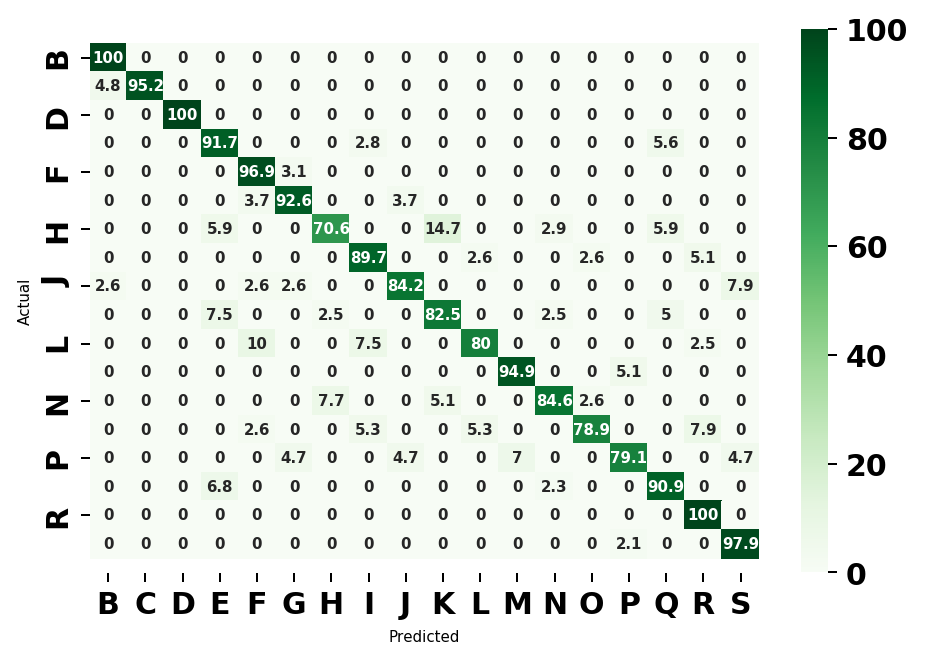

In [450]:
##### import pandas as pd
import seaborn as sn
font = {'family' : 'normal', 
        'weight' : 'bold',
        'size'   : 6}

plt.rc('font', **font) 
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12) 
Y_pred = mode_pred
Y_test_int = mode_orig 
data = {'y_Predicted': Y_pred,
        'y_Actual':    Y_test_int
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], normalize='index', rownames=['Actual'], 
                               colnames=['Predicted'], margins = False)\
.round(3)*100
fig = plt.figure(dpi=180)
sn.heatmap(confusion_matrix,annot=True, cmap="Greens", fmt='g') # cbar_kws={'format': '%.0f%%'},
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
cap = plt.gcf()
plt.savefig('results/final '+subj+' multitask multi input ctc.png', dpi = 400)
plt.show

In [451]:
Counter(mode_orig)

Counter({'B': 260,
         'C': 124,
         'K': 40,
         'L': 40,
         'M': 39,
         'D': 198,
         'E': 36,
         'F': 32,
         'G': 27,
         'N': 39,
         'O': 38,
         'P': 43,
         'H': 34,
         'I': 39,
         'J': 38,
         'Q': 44,
         'R': 45,
         'S': 47})

# Trigger Detect

In [452]:
pred_labels = []

for p in pred:
    label = []
    for num in p:
        if num == 20 or num == 1:# or chr(ord('@')+num) == 'A':
            continue
        label.append(num)
    if len(label) != 0:
        pred_labels.append(label)
pred_labels = np.array(pred_labels,dtype=object)  
print(pred_labels[3])
print(len(pred_labels))

[11, 11, 11, 11]
1163


In [453]:
prb_ls = []

for i in range(len(pred)):
    prb = []
    for j in range(len(pred[i])):
        if pred[i][j] == 20 or pred[i][j] == 1:# or chr(ord('@')+num) == 'A':
            continue
        prb.append(probs[i][j,:])
    if len(prb) != 0:
        prb_ls.append(prb)
prb_ls = np.array(prb_ls,dtype=object)  
print(len(prb_ls))

1163


In [454]:
# from collections import Counter
mode_orig = [max(Counter(np.argmax(y,-1)+1)) for y in y7test]
mode_pred = [max(Counter(y)) if len(y) != 0 else 1 for y in pred_labels]
print(len(mode_orig))
print(len(mode_pred))

1163
1163


In [455]:
from IPython.display import clear_output

In [456]:
asl_dict = {5:'Tired',6:'Book',7:'Sleep',8:'Evening',9:'Ready',10:'Hot',11:'Month',12:'Cook',13:'Again',
           14:'Summon',15:'Maybe',16:'Night',17:'Something',18:'Teacher',19:'Teach'}

In [556]:
# params
sign = range(5,20,1)
low_cf = 0.3 # 0.3 imit, 0.1 natv
high_cf = 0.99 # 0.99 imit, 0.95 ntv
samp_th = np.linspace(0.01,0.99,99)

In [542]:
def high_trig(sign,high_cf,samp_th):
    high_th = [round(len(y)*samp_th*high_cf) for y in y7test]
    scores = np.array([np.array(p)[:,sign] for p in prb_ls],dtype=object)
    acc_scores = np.array([sum(s) for s in scores],dtype=object)
    num_sign = sum(np.array(mode_orig)==sign)
    falses = 0
    rejects = 0
    for i in range(len(mode_orig)):
        if acc_scores[i] > high_th[i] and mode_orig[i] != sign:
            falses += 1
        if acc_scores[i] < high_th[i] and mode_orig[i] == sign:
            rejects += 1
    far = falses/num_sign
    frr = rejects/num_sign
    return far, frr, rejects, falses

In [543]:
def low_trig(sign,high_cf,low_cf,samp_th):
    high_th = [round(len(y)*samp_th*high_cf) for y in y7test]
    scores = np.array([np.array(p)[:,sign] for p in prb_ls],dtype=object)
    acc_scores = np.array([sum(s) for s in scores],dtype=object)
    num_sign = sum(np.array(mode_orig)==sign)
    falses = 0
    rejects = 0
    for i in range(len(mode_orig)):
        if acc_scores[i] > high_th[i] and mode_orig[i] != sign:
            falses += 1
        if acc_scores[i] < high_th[i] and mode_orig[i] == sign:
            cmp = np.nonzero(scores[i] > low_cf)[0]
            
            if cmp.size !=0:
                nnzlen = cmp[-1] - cmp[0]
#                 print(str(i)+ '. '+str(nnzlen))
                if nnzlen > len(y6test[i])/2: # /2
                    continue
            rejects += 1
    far = falses/num_sign
    frr = rejects/num_sign
    return far, frr, rejects, falses

In [544]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    hatches = ['/', '']
    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)],
                        hatch = hatches[i])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(),loc='best')

# Imitation Results

In [195]:
# high th
far_ls = np.zeros([len(sign),len(samp_th)])
frr_ls = np.zeros([len(sign),len(samp_th)])
rejects = np.zeros([len(sign),len(samp_th)])
falses = np.zeros([len(sign),len(samp_th)])
for i in range(len(sign)):
    for j in range(len(samp_th)):
        far_ls[i,j], frr_ls[i,j], rejects[i,j], falses[i,j] = high_trig(sign[i],high_cf,samp_th[j])
        clear_output(wait=True)
        print('Processing: '+str(i*len(samp_th)+j)+'/'+str(len(sign)*len(samp_th)))

Processing: 1484/1485


In [196]:
det_rates = 1 - sum(far_ls,frr_ls)
print('Max det rate: ' + str(np.max(det_rates)) + ', class: '+asl_dict[sign[np.argmax(np.amax(det_rates,-1),-1)]])

Max det rate: 0.7975268230587379, class: Teacher


In [197]:
maxes = np.amax(det_rates,-1)
maxes

array([0.54068922, 0.51712389, 0.40359244, 0.36796423, 0.47957811,
       0.53086016, 0.40998104, 0.61355246, 0.61120204, 0.50521913,
       0.44858395, 0.34966358, 0.41974905, 0.79752682, 0.6683397 ])

In [198]:
# low th
far_ls_low = np.zeros([len(sign),len(samp_th)])
frr_ls_low = np.zeros([len(sign),len(samp_th)])
rejects_low = np.zeros([len(sign),len(samp_th)])
falses_low = np.zeros([len(sign),len(samp_th)])
for i in range(len(sign)):
    for j in range(len(samp_th)):
        far_ls_low[i,j], frr_ls_low[i,j], rejects_low[i,j], falses_low[i,j] = low_trig(sign[i],high_cf,low_cf,samp_th[j])
        clear_output(wait=True)
        print('Processing: '+str(i*len(samp_th)+j)+'/'+str(len(sign)*len(samp_th)))

Processing: 1484/1485


In [199]:
det_rates_low = 1 - sum(far_ls_low,frr_ls_low)
max_val = np.max(det_rates_low)
max_idx = np.argmax(det_rates_low,0)

print('Max det rate: ' + str(max_val) + ', class: '+asl_dict[sign[np.argmax(np.amax(det_rates_low,-1),-1)]])

Max det rate: 0.9361702127659575, class: Teach


In [200]:
# min_val = np.min(rejects_low)
# min_idx = np.argmax(rejects_low,0)
# print('Min val: '+str(min_val)+', Min idx: '+str(min_idx))

In [201]:
maxes_low = np.amax(det_rates_low,-1)
maxes_low

array([0.80555556, 0.82142857, 0.74193548, 0.61764706, 0.87179487,
       0.79487179, 0.64285714, 0.825     , 0.92307692, 0.76923077,
       0.76315789, 0.57777778, 0.68888889, 0.93333333, 0.93617021])

In [193]:
# # param search
# low_cf = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7] # confidence
# high_cf = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99] # 0.8 confidence
# far_ls_low_ls = []
# frr_ls_low_ls = []
# rejects_low = []
# falses_low = []
# for low in range(len(low_cf)):
#     for high in range(len(high_cf)):
#         low_cfx = low_cf[low]
#         high_cfx = high_cf[high]
#         far_ls_low = np.zeros([len(sign),len(samp_th)])
#         frr_ls_low = np.zeros([len(sign),len(samp_th)])
#         rejects_low = np.zeros([len(sign),len(samp_th)])
#         falses_low = np.zeros([len(sign),len(samp_th)])
#         for i in range(len(sign)):
#             for j in range(len(samp_th)):
#                 far_ls_low[i,j], frr_ls_low[i,j], rejects_low[i,j], falses_low[i,j] = low_trig(sign[i],high_cfx,low_cfx,samp_th[j])
#                 clear_output(wait=True)
#                 print('Processing: '+str(low*len(low_cf)+high)+'/'+str(len(low_cf)*len(high_cf)))
#         far_ls_low_ls.append(far_ls_low)
#         far_ls_low_ls.append(far_ls_low)
#         far_ls_low_ls.append(far_ls_low)
#         far_ls_low_ls.append(far_ls_low)
        

In [202]:
data = {}
lsx = [maxes, maxes_low]
ls_th = ['Single Threshold', 'Double Threshold']
for key in ls_th:
    for val in lsx:
        data[key] = val
        lsx.remove(val)
        break

In [203]:
csfont = {'fontname': 'Comic Sans MS'}

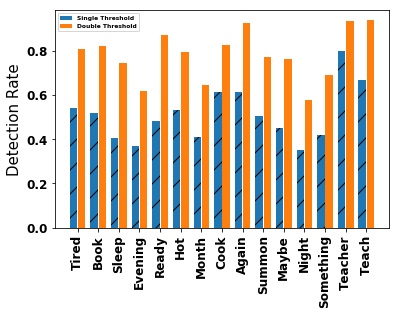

In [205]:
fig, ax = plt.subplots()
bar_plot(ax, data, total_width=.8, single_width=.9)
plt.rcParams['font.family'] = 'Comic Sans MS'
plt.xticks(range(15), asl_dict.values())
plt.xticks(rotation = 90)
plt.ylabel('Detection Rate',fontsize=15, weight='normal', **csfont)
plt.savefig('results/final imit comp th.png', bbox_inches='tight', dpi=500)

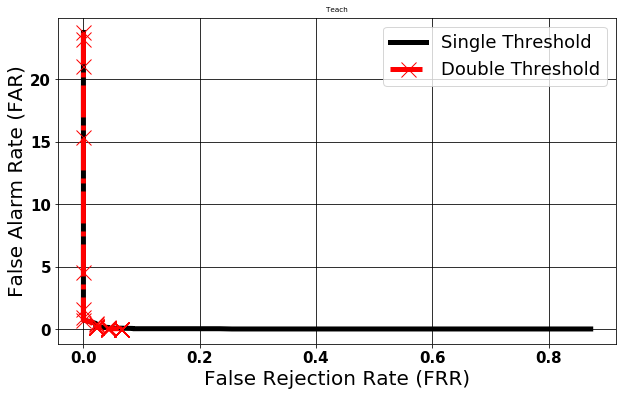

In [222]:
# p1, = plt.plot(frr_ls[14],far_ls[14])
# p2, = plt.plot(frr_ls[11],far_ls[11],'-xr')
idx = 14 #8
# for idx in range(8,9): # plotted with low thesold diving factor of 20, not 2
plt.figure()
p1, = plt.plot(frr_ls[idx],far_ls[idx],'k',linewidth=5)
p2, = plt.plot(frr_ls_low[idx],far_ls_low[idx],'-.xr',linewidth=5,markersize=15)
matplotlib.rc('xtick',labelsize=15)
matplotlib.rc('ytick',labelsize=15)
plt.xlabel('False Rejection Rate (FRR)',fontsize=20, weight='normal')
plt.ylabel('False Alarm Rate (FAR)',fontsize=20, weight='normal')
plt.legend([p1,p2], ('Single Threshold', 'Double Threshold'), fontsize=20,
           prop={'weight':'normal','size':18},loc='best')
plt.title(asl_dict[idx+5])
plt.grid(color='k')
# plt.ylim([-0.2,0.2])
# plt.xlim([0,0.007])
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.savefig('results/final imit teach double th.png', bbox_inches='tight', dpi = 500)

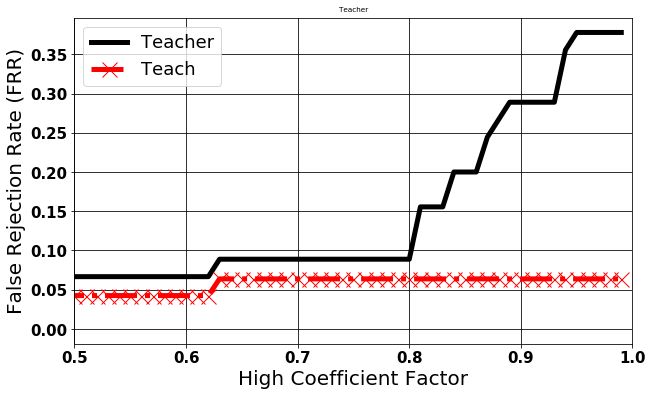

In [220]:
# p1, = plt.plot(frr_ls[14],far_ls[14])
# p2, = plt.plot(frr_ls[11],far_ls[11],'-xr')
idx = 13 # maybe = 10
idx2 = 14 # teacher = 13
plt.figure()
# p1, = plt.plot(frr_ls[idx],far_ls[idx],'k',linewidth=5)
# p2, = plt.plot(frr_ls_low[idx2],far_ls_low[idx2],'-.xr',linewidth=5,markersize=15)
p1, = plt.plot(samp_th, frr_ls[idx],'k',linewidth=5)
p2, = plt.plot(samp_th, frr_ls_low[idx2],'-.xr',linewidth=5,markersize=15)
matplotlib.rc('xtick',labelsize=15)
matplotlib.rc('ytick',labelsize=15)
# plt.xlabel('False Rejection Rate (FRR)',fontsize=20, weight='normal')
# plt.ylabel('False Alarm Rate (FAR)',fontsize=20, weight='normal')
plt.ylabel('False Rejection Rate (FRR)',fontsize=20, weight='normal')
plt.xlabel('High Coefficient Factor',fontsize=20, weight='normal')
plt.legend([p1,p2], ('Teacher', 'Teach'), fontsize=20,
           prop={'weight':'normal','size':18},loc='best')
plt.title(asl_dict[idx+5])
plt.grid(color='k')
# plt.ylim([0,5])
plt.xlim([0.5,1])
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.savefig('results/final imit teacher vs teach.png', bbox_inches='tight', dpi = 500)

# Native Results

In [168]:
# high th
far_ls = np.zeros([len(sign),len(samp_th)])
frr_ls = np.zeros([len(sign),len(samp_th)])
rejects = np.zeros([len(sign),len(samp_th)])
falses = np.zeros([len(sign),len(samp_th)])
for i in range(len(sign)):
    for j in range(len(samp_th)):
        far_ls[i,j], frr_ls[i,j], rejects[i,j], falses[i,j] = high_trig(sign[i],high_cf,samp_th[j])
        clear_output(wait=True)
        print('Processing: '+str(i*len(samp_th)+j)+'/'+str(len(sign)*len(samp_th)))

Processing: 1484/1485


In [169]:
det_rates = 1 - np.add(far_ls,frr_ls)
print('Max det rate: ' + str(np.max(det_rates)) + ', class: '+asl_dict[sign[np.argmax(np.amax(det_rates,-1),-1)]])

Max det rate: 0.9130434782608696, class: Teacher


In [170]:
# print(far_ls[-2])
# print(frr_ls[-2])
# print(1-np.add(far_ls[-2],frr_ls[-2]))

In [171]:
maxes = np.amax(det_rates,-1)
maxes = np.array([m if m != 0 else 0.12 for m in maxes])
maxes

array([0.72222222, 0.46268657, 0.01923077, 0.27173913, 0.48913043,
       0.58947368, 0.06666667, 0.53246753, 0.47560976, 0.35106383,
       0.61627907, 0.46      , 0.54455446, 0.91304348, 0.76315789])

In [172]:
# low th
far_ls_low = np.zeros([len(sign),len(samp_th)])
frr_ls_low = np.zeros([len(sign),len(samp_th)])
rejects_low = np.zeros([len(sign),len(samp_th)])
falses_low = np.zeros([len(sign),len(samp_th)])
for i in range(len(sign)):
    for j in range(len(samp_th)):
        far_ls_low[i,j], frr_ls_low[i,j], rejects_low[i,j], falses_low[i,j] = low_trig(sign[i],high_cf,low_cf,samp_th[j])
        clear_output(wait=True)
        print('Processing: '+str(i*len(samp_th)+j)+'/'+str(len(sign)*len(samp_th)))

Processing: 1484/1485


In [173]:
det_rates_low = 1 - np.add(far_ls_low,frr_ls_low)
max_val = np.max(det_rates_low)
max_idx = np.argmax(det_rates_low,0)

print('Max det rate: ' + str(max_val) + ', class: '+asl_dict[sign[np.argmax(np.amax(det_rates_low,-1),-1)]])

Max det rate: 0.9891304347826086, class: Teacher


In [174]:
# min_val = np.min(rejects_low)
# min_idx = np.argmax(rejects_low,0)
# print('Min val: '+str(min_val)+', Min idx: '+str(min_idx))

In [183]:
# print(np.argmax(1-np.add(far_ls_low[-2],frr_ls_low[-2]),-1))
# print(far_ls_low[-2])
# print(frr_ls_low[-2])
# print(1-np.add(far_ls_low[-2],frr_ls_low[-2]))

In [176]:
maxes_low = np.amax(det_rates_low,-1)
maxes_low

array([0.76851852, 0.6119403 , 0.52884615, 0.44565217, 0.70652174,
       0.70526316, 0.43333333, 0.74025974, 0.67073171, 0.46808511,
       0.80232558, 0.58      , 0.57425743, 0.98913043, 0.77192982])

In [177]:
data = {}
lsx = [maxes, maxes_low]
ls_th = ['Single Threshold', 'Double Threshold']
for key in ls_th:
    for val in lsx:
        data[key] = val
        lsx.remove(val)
        break

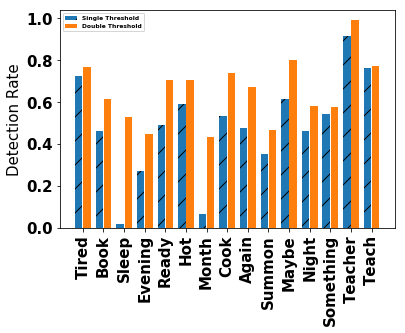

In [178]:
fig, ax = plt.subplots()
bar_plot(ax, data, total_width=.8, single_width=.9)
plt.rcParams['font.family'] = 'Comic Sans MS'
plt.xticks(range(15), asl_dict.values())
plt.xticks(rotation = 90)
plt.ylabel('Detection Rate',fontsize=15, weight='normal')
plt.savefig('results/final native comp th.png', bbox_inches='tight', dpi=500)

In [179]:
# # p1, = plt.plot(frr_ls[14],far_ls[14])
# # p2, = plt.plot(frr_ls[11],far_ls[11],'-xr')
# idx = 13 #8
# # for idx in range(8,9): # plotted with low thesold diving factor of 20, not 2
# plt.figure()
# p1, = plt.plot(frr_ls[idx],far_ls[idx],'k',linewidth=5)
# p2, = plt.plot(frr_ls_low[idx],far_ls_low[idx],'-.xr',linewidth=5,markersize=15)
# matplotlib.rc('xtick',labelsize=15)
# matplotlib.rc('ytick',labelsize=15)
# plt.xlabel('False Rejection Rate (FRR)',fontsize=20, weight='normal')
# plt.ylabel('False Alarm Rate (FAR)',fontsize=20, weight='normal')
# plt.legend([p1,p2], ('Single Threshold', 'Double Threshold'), fontsize=20,
#            prop={'weight':'normal','size':18},loc='best')
# plt.title(asl_dict[idx+5])
# plt.grid(color='k')
# # plt.ylim([-0.2,0.2])
# # plt.xlim([0,0.007])
# fig = plt.gcf()
# fig.set_size_inches(10,6)
# plt.savefig('results/final '+subj+' teach double th.png', bbox_inches='tight', dpi = 500)

In [180]:
# # p1, = plt.plot(frr_ls[14],far_ls[14])
# # p2, = plt.plot(frr_ls[11],far_ls[11],'-xr')
# idx = 13 # maybe = 10
# idx2 = 14 # teacher = 13
# plt.figure()
# # p1, = plt.plot(frr_ls[idx],far_ls[idx],'k',linewidth=5)
# # p2, = plt.plot(frr_ls_low[idx2],far_ls_low[idx2],'-.xr',linewidth=5,markersize=15)
# p1, = plt.plot(samp_th, frr_ls[idx],'k',linewidth=5)
# p2, = plt.plot(samp_th, frr_ls_low[idx2],'-.xr',linewidth=5,markersize=15)
# matplotlib.rc('xtick',labelsize=15)
# matplotlib.rc('ytick',labelsize=15)
# # plt.xlabel('False Rejection Rate (FRR)',fontsize=20, weight='normal')
# # plt.ylabel('False Alarm Rate (FAR)',fontsize=20, weight='normal')
# plt.ylabel('False Rejection Rate (FRR)',fontsize=20, weight='normal')
# plt.xlabel('High Coefficient Factor',fontsize=20, weight='normal')
# plt.legend([p1,p2], ('Teacher', 'Teach'), fontsize=20,
#            prop={'weight':'normal','size':18},loc='best')
# plt.title(asl_dict[idx+5])
# plt.grid(color='k')
# # plt.ylim([0,5])
# plt.xlim([0.5,1])
# fig = plt.gcf()
# fig.set_size_inches(10,6)
# plt.savefig('results/final '+subj+' teacher vs teach.png', bbox_inches='tight', dpi = 500)

# Subj Results

In [545]:
# high th
far_ls = np.zeros([len(sign),len(samp_th)])
frr_ls = np.zeros([len(sign),len(samp_th)])
rejects = np.zeros([len(sign),len(samp_th)])
falses = np.zeros([len(sign),len(samp_th)])
for i in range(len(sign)):
    for j in range(len(samp_th)):
        far_ls[i,j], frr_ls[i,j], rejects[i,j], falses[i,j] = high_trig(sign[i],high_cf,samp_th[j])
        clear_output(wait=True)
        print('Processing: '+str(i*len(samp_th)+j)+'/'+str(len(sign)*len(samp_th)))

Processing: 1484/1485


In [546]:
det_rates = 1 - np.add(far_ls,frr_ls)
print('Max det rate: ' + str(np.max(det_rates)) + ', class: '+asl_dict[sign[np.argmax(np.amax(det_rates,-1),-1)]])

Max det rate: 0.9333333333333333, class: Teacher


In [547]:
# print(far_ls[-2])
# print(frr_ls[-2])
# print(1-np.add(far_ls[-2],frr_ls[-2]))

In [548]:
maxes = np.amax(det_rates,-1)
# maxes = np.array([m if m != 0 else 0.12 for m in maxes])
maxes

array([0.83333333, 0.78571429, 0.87096774, 0.67647059, 0.82051282,
       0.79487179, 0.66666667, 0.825     , 0.87179487, 0.79487179,
       0.86842105, 0.68888889, 0.77272727, 0.93333333, 0.89361702])

In [557]:
# low th
far_ls_low = np.zeros([len(sign),len(samp_th)])
frr_ls_low = np.zeros([len(sign),len(samp_th)])
rejects_low = np.zeros([len(sign),len(samp_th)])
falses_low = np.zeros([len(sign),len(samp_th)])
for i in range(len(sign)):
    for j in range(len(samp_th)):
        far_ls_low[i,j], frr_ls_low[i,j], rejects_low[i,j], falses_low[i,j] = low_trig(sign[i],high_cf,low_cf,samp_th[j])
        clear_output(wait=True)
        print('Processing: '+str(i*len(samp_th)+j)+'/'+str(len(sign)*len(samp_th)))

Processing: 1484/1485


In [558]:
det_rates_low = 1 - np.add(far_ls_low,frr_ls_low)
max_val = np.max(det_rates_low)
max_idx = np.argmax(det_rates_low,0)

print('Max det rate: ' + str(max_val) + ', class: '+asl_dict[sign[np.argmax(np.amax(det_rates_low,-1),-1)]])

Max det rate: 0.9555555555555556, class: Teacher


In [559]:
# min_val = np.min(rejects_low)
# min_idx = np.argmax(rejects_low,0)
# print('Min val: '+str(min_val)+', Min idx: '+str(min_idx))

In [560]:
# print(far_ls_low[-2])
# print(frr_ls_low[-2])
# print(1-np.add(far_ls_low[-2],frr_ls_low[-2]))

In [561]:
maxes_low = np.amax(det_rates_low,-1)
maxes_low

array([0.83333333, 0.89285714, 0.87096774, 0.70588235, 0.87179487,
       0.84615385, 0.66666667, 0.825     , 0.92307692, 0.79487179,
       0.86842105, 0.68888889, 0.77272727, 0.95555556, 0.93617021])

In [562]:
data = {}
lsx = [maxes, maxes_low]
ls_th = ['Single Threshold', 'Double Threshold']
for key in ls_th:
    for val in lsx:
        data[key] = val
        lsx.remove(val)
        break

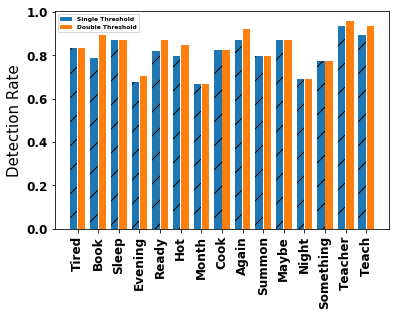

In [563]:
fig, ax = plt.subplots()
bar_plot(ax, data, total_width=.8, single_width=.9)
plt.rcParams['font.family'] = 'Comic Sans MS'
plt.xticks(range(15), asl_dict.values())
plt.xticks(rotation = 90)
plt.ylabel('Detection Rate',fontsize=15, weight='normal')
plt.savefig('results/final '+subj+' comp th.png', bbox_inches='tight', dpi=500)

In [471]:
# # p1, = plt.plot(frr_ls[14],far_ls[14])
# # p2, = plt.plot(frr_ls[11],far_ls[11],'-xr')
# idx = 13 #8
# # for idx in range(8,9): # plotted with low thesold diving factor of 20, not 2
# plt.figure()
# p1, = plt.plot(frr_ls[idx],far_ls[idx],'k',linewidth=5)
# p2, = plt.plot(frr_ls_low[idx],far_ls_low[idx],'-.xr',linewidth=5,markersize=15)
# matplotlib.rc('xtick',labelsize=15)
# matplotlib.rc('ytick',labelsize=15)
# plt.xlabel('False Rejection Rate (FRR)',fontsize=20, weight='normal')
# plt.ylabel('False Alarm Rate (FAR)',fontsize=20, weight='normal')
# plt.legend([p1,p2], ('Single Threshold', 'Double Threshold'), fontsize=20,
#            prop={'weight':'normal','size':18},loc='best')
# plt.title(asl_dict[idx+5])
# plt.grid(color='k')
# # plt.ylim([-0.2,0.2])
# # plt.xlim([0,0.007])
# fig = plt.gcf()
# fig.set_size_inches(10,6)
# plt.savefig('results/final '+subj+' teach double th.png', bbox_inches='tight', dpi = 500)

In [472]:
# # p1, = plt.plot(frr_ls[14],far_ls[14])
# # p2, = plt.plot(frr_ls[11],far_ls[11],'-xr')
# idx = 13 # maybe = 10
# idx2 = 14 # teacher = 13
# plt.figure()
# # p1, = plt.plot(frr_ls[idx],far_ls[idx],'k',linewidth=5)
# # p2, = plt.plot(frr_ls_low[idx2],far_ls_low[idx2],'-.xr',linewidth=5,markersize=15)
# p1, = plt.plot(samp_th, frr_ls[idx],'k',linewidth=5)
# p2, = plt.plot(samp_th, frr_ls_low[idx2],'-.xr',linewidth=5,markersize=15)
# matplotlib.rc('xtick',labelsize=15)
# matplotlib.rc('ytick',labelsize=15)
# # plt.xlabel('False Rejection Rate (FRR)',fontsize=20, weight='normal')
# # plt.ylabel('False Alarm Rate (FAR)',fontsize=20, weight='normal')
# plt.ylabel('False Rejection Rate (FRR)',fontsize=20, weight='normal')
# plt.xlabel('High Coefficient Factor',fontsize=20, weight='normal')
# plt.legend([p1,p2], ('Teacher', 'Teach'), fontsize=20,
#            prop={'weight':'normal','size':18},loc='best')
# plt.title(asl_dict[idx+5])
# plt.grid(color='k')
# # plt.ylim([0,5])
# plt.xlim([0.5,1])
# fig = plt.gcf()
# fig.set_size_inches(10,6)
# plt.savefig('results/final '+subj+' teacher vs teach.png', bbox_inches='tight', dpi = 500)